In [4]:
#CIS600 - Evolutionary Machine Learning
# Homework 2
# Instructor = Professor C.K. Mohan
# T.A. = Subodh Kalia
# Author = Suket Singh SUID: 923277656

In [5]:
##importing all the packages
import numpy as np
import pandas as pd
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split
from keras.layers import LSTM, Input, Dense
from keras.models import Model
from keras.models import Sequential
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
np.random.seed(1000)
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [6]:
dataset_sinewave = pd.read_csv('Sinewave.csv', header=0)

In [7]:
generate_data = dataset_sinewave.values
generate_data = generate_data.astype('float32')
features = 1

# The following code converts an array of values to a dataset matrix.
def create_dataset(data, feature):
    data_one, data_two = [], []
    for i in range(len(data) - feature):
        x = data[i:(i + feature), 0]
        data_one.append(x)
        data_two.append(data[i + feature, 0])
    return np.array(data_one), np.array(data_two)

# Split the dataset into train and test sets.
set_train = int(len(generate_data) * 0.8)
set_test = len(generate_data) - set_train
train_data, test_data = generate_data[0:set_train,:], generate_data[set_train:len(generate_data),:]
print(len(train_data), len(test_data))
print('train_data Shape: ', train_data.shape)

q_train, w_train = create_dataset(train_data, features)
q_test, w_test = create_dataset(test_data, features)

# reshape input is [samples, time steps, features]
q_train = np.reshape(q_train, (q_train.shape[0], 1, features))
q_test = np.reshape(q_test, (q_test.shape[0], 1, features))

print(q_train.shape)

4000 1001
train_data Shape:  (4000, 1)
(3999, 1, 1)


In [8]:
model = Sequential()
model.add(LSTM(8, input_shape=(q_train.shape[1],q_train.shape[2])))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer='sgd')

print(model.summary())
print(q_train.shape[1], q_train.shape[2])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
None
1 1


In [9]:
# the following code gives the weights and biases for layer.
weights_input_layer = model.layers[0].get_weights()[0]
biases_input_layer = model.layers[0].get_weights()[1]

weights_output_layer = model.layers[1].get_weights()[0]
biases_output_layer = model.layers[1].get_weights()[1]

# The following code prints the shapes of weights and biases for each layer.
print(np.shape(weights_input_layer))
print(np.shape(biases_input_layer))
print(np.shape(weights_output_layer))
print(np.shape(biases_output_layer))

(1, 32)
(8, 32)
(8, 1)
(1,)


In [10]:
def train_assess(ind_sol):   
    
    # for window_size and num_units we decode GA solution to integer.
    a = np.array(ind_sol[0:32]).reshape(1,32)
    b = np.array(ind_sol[32:288]).reshape(8,32)
    c = np.array(ind_sol[288:320]).reshape(32,)
    d = np.array(ind_sol[320:328]).reshape(8,1)
    e = np.array(ind_sol[328:329]).reshape(1,)
    
    model.layers[0].set_weights([a,b,c])
    model.layers[1].set_weights([d,e])
    
    pred_t = model.predict(q_train)

    # RMSE score is calculates as fitness score for GA
    rmse = np.sqrt(mean_squared_error(w_train, pred_t))
    
    return rmse,

In [11]:
population_size = 24
num_generations = 400
individual_length = 329

#To minimize RMSE score, we use -1.0, for maximimzing we could have used 1.0.

creator.create('FitnessMax', base.Fitness, weights = (-1, ))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('attr_float', random.uniform, -1, 1)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_float, n = individual_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

toolbox.register('mate', tools.cxBlend, alpha = .9)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.1)
toolbox.register('select', tools.selTournament, tournsize = 2)
toolbox.register('evaluate', train_assess)

population = toolbox.population(n = population_size)
r, logbook = algorithms.eaSimple(population, toolbox, cxpb = 0.1, mutpb = 0.2, 
                                 stats = stats, ngen = num_generations, verbose = True)

gen	nevals	avg     	std     	min     	max    
0  	24    	0.936602	0.234118	0.539622	1.38763
1  	2     	0.759023	0.171108	0.539622	1.25255
2  	11    	0.692487	0.152875	0.393417	1.13503
3  	6     	0.638009	0.203189	0.393417	1.28367
4  	5     	0.553358	0.155029	0.348848	0.796425
5  	4     	0.468165	0.166287	0.304836	1.00631 
6  	2     	0.408277	0.116719	0.348848	0.961033
7  	6     	0.441266	0.225003	0.348848	1.47953 
8  	7     	0.431502	0.149379	0.348848	0.936534
9  	7     	0.417503	0.120367	0.313668	0.866063
10 	8     	0.36048 	0.0399169	0.313668	0.524461
11 	8     	0.442246	0.243498 	0.235782	1.35402 
12 	9     	0.426942	0.186228 	0.224036	0.910789
13 	7     	0.413363	0.185819 	0.127514	0.940952
14 	8     	0.364901	0.172031 	0.235782	1.02008 
15 	5     	0.288426	0.075333 	0.198452	0.541605
16 	2     	0.320743	0.234229 	0.198452	1.39819 
17 	9     	0.273995	0.086579 	0.158417	0.516396
18 	4     	0.311197	0.222225 	0.158417	1.12801 
19 	7     	0.371518	0.340825 	0.158417	1.54748 
20 	3   

166	8     	0.16836  	0.196088 	0.0527855	0.848155
167	6     	0.122593 	0.169181 	0.0527855	0.687307
168	4     	0.107412 	0.168776 	0.0527855	0.787493
169	4     	0.124354 	0.16421  	0.0527855	0.61768 
170	6     	0.109525 	0.132297 	0.0527855	0.530501
171	10    	0.12207  	0.178643 	0.0527855	0.805197
172	6     	0.127698 	0.174973 	0.0527855	0.764618
173	7     	0.169279 	0.233204 	0.0527855	0.805584
174	5     	0.0900006	0.0999636	0.0527855	0.406011
175	5     	0.105955 	0.220255 	0.0527855	1.15595 
176	12    	0.205521 	0.276487 	0.0527855	1.02251 
177	4     	0.110889 	0.245882 	0.0527855	1.27904 
178	3     	0.089264 	0.115778 	0.0527855	0.594221
179	6     	0.156896 	0.222648 	0.0527855	0.893752
180	6     	0.126968 	0.155605 	0.0527855	0.679422
181	8     	0.142277 	0.235823 	0.0527855	0.958911
182	7     	0.204478 	0.344409 	0.0527855	1.59581 
183	11    	0.266294 	0.273929 	0.0527855	0.865011
184	7     	0.223515 	0.244085 	0.0527855	0.937128
185	7     	0.227034 	0.255424 	0.0527855	0.750746


330	5     	0.14584  	0.2056   	0.0477043	0.805359
331	6     	0.355998 	0.950243 	0.0477043	4.79399 
332	10    	0.184481 	0.24125  	0.0477043	0.826661
333	3     	0.0833868	0.122334 	0.0477043	0.583232
334	6     	0.150219 	0.268935 	0.0477043	1.20372 
335	9     	0.188562 	0.261263 	0.0477043	0.969608
336	3     	0.128358 	0.158216 	0.0477043	0.487295
337	8     	0.237339 	0.371417 	0.0477043	1.41909 
338	3     	0.157698 	0.221714 	0.0477043	0.945012
339	6     	0.131516 	0.150866 	0.0477043	0.473258
340	1     	0.0654557	0.0851326	0.0477043	0.473737
341	10    	0.172005 	0.199861 	0.0477043	0.775841
342	7     	0.24642  	0.444982 	0.0477043	2.1545  
343	4     	0.125073 	0.124895 	0.0477043	0.481183
344	7     	0.281346 	0.708012 	0.0477043	3.57443 
345	3     	0.0955807	0.169338 	0.0477043	0.82604 
346	10    	0.136362 	0.192799 	0.0477043	0.793994
347	7     	0.292448 	0.877459 	0.0477043	4.42289 
348	12    	0.225728 	0.306766 	0.0477043	1.07952 
349	5     	0.111686 	0.21751  	0.0477043	1.10465 


In [12]:

##printing top N solutions.
supreme_individuals = tools.selBest(population,k = 1)

for bi in supreme_individuals:
    a = np.array(bi[0:32]).reshape(1,32)
    b = np.array(bi[32:288]).reshape(8,32)
    c = np.array(bi[288:320]).reshape(32,)
    d = np.array(bi[320:328]).reshape(8,1)
    e = np.array(bi[328:329]).reshape(1,)
    
    model.layers[0].set_weights([a,b,c])
    model.layers[1].set_weights([d,e])  
    

In [39]:
from sklearn.metrics import r2_score
p_train = model.predict(q_train)
p_test = model.predict(q_test)
print('Score for Train R2: ', r2_score(w_train, p_train))
print('Score for Test R2: ', r2_score(w_test, p_test))

Score for Train R2:  0.993906249837113
Score for Test R2:  0.9939071060869707


In [3]:
#importing packages for plotting purpose
import math
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from matplotlib.pylab import rcParams
from IPython.display import clear_output
matplotlib.style.use('ggplot')

print('MSE Test Data: ', math.sqrt(mean_squared_error(w_test, p_test)))
print('MSE Train Data: ', math.sqrt(mean_squared_error(w_train, p_train)))


# for plotting shift the train predictions
train_Plot = np.empty_like(generate_data)
train_Plot[:, :] = np.nan
train_Plot[features:len(p_train)+features, :] = p_train

#for plotting shift the test predictions.
test_Plot = np.empty_like(generate_data)
test_Plot[:, :] = np.nan
test_Plot[len(p_train)+features:len(generate_data)-features, :] = p_test

#basiline and predictions are plotted
plt.figure(figsize=(20,10))
plt.plot(generate_data, color='b')
plt.plot(train_Plot, color='darkorange')
plt.plot(test_Plot, color='mediumspringgreen')
plt.show

NameError: name 'mean_squared_error' is not defined

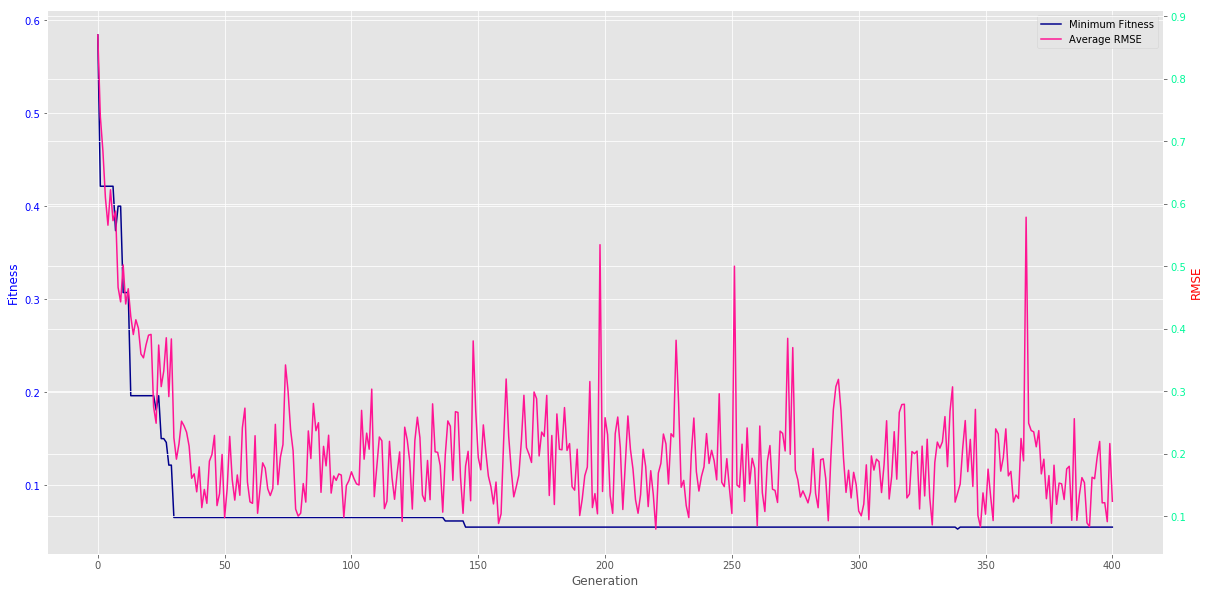

In [48]:
gen = logbook.select("gen")
size_avgs = logbook.select("avg")
fit_mins = logbook.select("min")

plt.rcParams['figure.figsize'] = [20, 10]
fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness", color="darkblue")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, size_avgs, "r-", label="Average RMSE", color = "deeppink")
ax2.set_ylabel("RMSE", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("mediumspringgreen")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)

plt.show()